In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import os
import conda_installer
from rdkit import Chem
from deepchem.feat.graph_features import atom_features as get_atom_features
import rdkit
import pickle
import matplotlib.pyplot as plt

2025-04-30 19:05:41.516125: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-30 19:05:41.583399: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
No normalization for NumAmideBonds. Feature removed!
No normalization for NumAtomStereoCenters. Feature removed!
No normalization for NumBridgeheadAtoms. Feature removed!
No normalization for NumHeterocycles. Feature removed!
No normaliz

In [2]:
PDBs = pickle.load(open('Datasets/PDBs_RDKit.pkl', 'rb'))
df = pd.read_csv('Datasets/T_data.csv')


In [3]:
# PDBs

In [4]:
# len(PDBs), df

In [5]:
info = []
for pdb in list(PDBs.keys()):
    info.append(df[df['Id'] == pdb][['TS_comp', 'TS_host', 'TS_ligand']].to_numpy()[0])

In [6]:
len(info)

103

In [7]:
from models.dcFeaturizer import atom_features as get_atom_features
def featurize(molecule, info):
    
    atom_features = []
    for atom in molecule.GetAtoms():
        new_feature = get_atom_features(atom).tolist()
        position = molecule.GetConformer().GetAtomPosition(atom.GetIdx())
        new_feature += [atom.GetMass(), atom.GetAtomicNum(),atom.GetFormalCharge()]
        new_feature += [position.x, position.y, position.z]
        for neighbor in atom.GetNeighbors()[:2]:
            neighbor_idx = neighbor.GetIdx()
            new_feature += [neighbor_idx]
        for i in range(2 - len(atom.GetNeighbors())):
            new_feature += [-1]

        atom_features.append(np.concatenate([new_feature, info], 0))
    return np.array(atom_features)

In [8]:
X = []
y = []
for i, pdb in enumerate(list(PDBs.keys())):
    X.append(featurize(PDBs[pdb], info[i]))
    y.append(df[df['Id'] == pdb]['exp'].to_numpy()[0])

In [9]:
X[0].shape, y[0]

((100, 41), -0.9)

In [10]:
len(y)

103

In [11]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
# Randomly shuffles the data before splitting, ensuring that the training and testing sets are representative of the overall dataset.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)


In [12]:
len(X_train), len(X_test), len(y_train), len(y_test)

(82, 21, 82, 21)

In [13]:
# for i, x in enumerate(X_test):
#     print(f"Sample {i}: shape = {x.shape}")

In [14]:
# Import custom layers
import importlib
import models.layers_update_mobley as layers
import keras.backend as K
import copy
from tensorflow.keras.callbacks import EarlyStopping


class PGGCNModel(tf.keras.Model):
    def __init__(self, num_atom_features=36, r_out_channel=20, c_out_channel=128):
        super().__init__()
        self.ruleGraphConvLayer = layers.RuleGraphConvLayer(r_out_channel, num_atom_features, 0)
        self.ruleGraphConvLayer.combination_rules = []
        self.conv = layers.ConvLayer(c_out_channel, r_out_channel)
        self.dense1 = tf.keras.layers.Dense(32, activation='relu', name='dense1')
        self.dense5 = tf.keras.layers.Dense(16, activation='relu', name='dense2')
        self.dense6 = tf.keras.layers.Dense(1, name='dense6')
        self.dense7 = tf.keras.layers.Dense(1, name='dense7',
                                            kernel_initializer=tf.keras.initializers.Constant([-.3, -1, 1, 1]),
                                            bias_initializer=tf.keras.initializers.Zeros())

    def addRule(self, rule, start_index, end_index=None):
        self.ruleGraphConvLayer.addRule(rule, start_index, end_index)

    def set_input_shapes(self, i_s):
        self.i_s = i_s

    def call(self, inputs):
        physics_info = inputs[:, 0, 38:]
        x_a = []
        for i in range(len(self.i_s)):
            x_a.append(inputs[i][:self.i_s[i], :38])
        x = self.ruleGraphConvLayer(x_a)
        x = self.conv(x)
        x = self.dense1(x)
        x = self.dense5(x)
        model_var = self.dense6(x)
        merged = tf.concat([model_var, physics_info], axis=1)
        out = self.dense7(merged)
        return out

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred[0] - y_true))) + K.abs(1 / K.mean(.2 + y_pred[1]))


def pure_rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

m = PGGCNModel()
m.addRule("sum", 0, 32)
m.addRule("multiply", 32, 33)
m.addRule("distance", 33, 36)
opt = tf.keras.optimizers.Adam(learning_rate=0.005)
m.compile(loss=pure_rmse, optimizer=opt)

input_shapes = []
for i in range(len(X_train)):
    input_shapes.append(np.array(X_train[i]).shape[0])
m.set_input_shapes(input_shapes)
for i in range(len(X_train)):
    if X_train[i].shape[0] < 2000:
        new_list = np.zeros([2000 - X_train[i].shape[0], 41])
        X_train[i] = np.concatenate([X_train[i], new_list], 0)
X_train = np.array(X_train)
x_c = copy.deepcopy(X_train)
y_train = np.array(y_train)
early_stop = EarlyStopping(
    monitor='loss',           
    patience=10,              
    restore_best_weights=True, 
    min_delta=0.001,          
    verbose=1                 
)
hist = m.fit(X_train, y_train, epochs = 500, batch_size=len(X_train), callbacks=[early_stop])

Epoch 1/500


2025-04-30 19:06:35.995321: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-04-30 19:06:35.995356: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (curie.cluster): /proc/driver/nvidia/version does not exist
2025-04-30 19:06:35.996134: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
1/1 [==============================] - 81s 81s/step - loss: 13.0894
Epoch 2/500
1/1 [==============================] - 1s 1s/step - loss: 10.9778
Epoch 3/500
1/1 [==============================] - 1s 859ms/step - loss: 8.9258
Epoch 4/500
1/1 [==============================] - 1s 1s/step - loss: 6.9871
Epoch 5/500
1/1 [==============================] - 1s 1s/step - loss: 5.2876
Epoch 6/500
1/1 [==============================] - 1s 1s/step - loss: 4.1243
Epoch 7/500
1/1 [==============================] - 1s 1s/step - loss: 3.9238
Epoch 8/500
1/1 [==============================] - 1s 1s/step - loss: 4.5183
Epoch 9/500
1/1 [==============================] - 1s 1s/step - loss: 5.2145
Epoch 10/500
1/1 [==============================] - 1s 1s/step - loss: 5.6633
Epoch 11/500
1/1 [===============

1/1 [==============================] - 1s 1s/step - loss: 3.7950
Epoch 101/500
1/1 [==============================] - 1s 1s/step - loss: 3.7946
Epoch 102/500
1/1 [==============================] - 1s 1s/step - loss: 3.7943
Epoch 103/500
1/1 [==============================] - 1s 1s/step - loss: 3.7938
Epoch 104/500
1/1 [==============================] - 1s 1s/step - loss: 3.7933
Epoch 105/500
1/1 [==============================] - 1s 1s/step - loss: 3.7928
Epoch 106/500
1/1 [==============================] - 1s 1s/step - loss: 3.7923
Epoch 107/500
1/1 [==============================] - 1s 1s/step - loss: 3.7919
Epoch 108/500
1/1 [==============================] - 1s 1s/step - loss: 3.7915
Epoch 109/500
1/1 [==============================] - 1s 1s/step - loss: 3.7911
Epoch 110/500
1/1 [==============================] - 1s 1s/step - loss: 3.7906
Epoch 111/500
1/1 [==============================] - 1s 1s/step - loss: 3.7901
Epoch 112/500
1/1 [==============================] - 1s 1s/step - 

1/1 [==============================] - 1s 1s/step - loss: 3.5718
Epoch 307/500
1/1 [==============================] - 1s 1s/step - loss: 3.5698
Epoch 308/500
1/1 [==============================] - 1s 1s/step - loss: 3.5678
Epoch 309/500
1/1 [==============================] - 1s 1s/step - loss: 3.5658
Epoch 310/500
1/1 [==============================] - 1s 1s/step - loss: 3.5638
Epoch 311/500
1/1 [==============================] - 1s 1s/step - loss: 3.5617
Epoch 312/500
1/1 [==============================] - 1s 1s/step - loss: 3.5597
Epoch 313/500
1/1 [==============================] - 1s 1s/step - loss: 3.5576
Epoch 314/500
1/1 [==============================] - 1s 1s/step - loss: 3.5555
Epoch 315/500
1/1 [==============================] - 1s 1s/step - loss: 3.5535
Epoch 316/500
1/1 [==============================] - 1s 1s/step - loss: 3.5514
Epoch 317/500
1/1 [==============================] - 1s 1s/step - loss: 3.5493
Epoch 318/500
1/1 [==============================] - 1s 1s/step - 

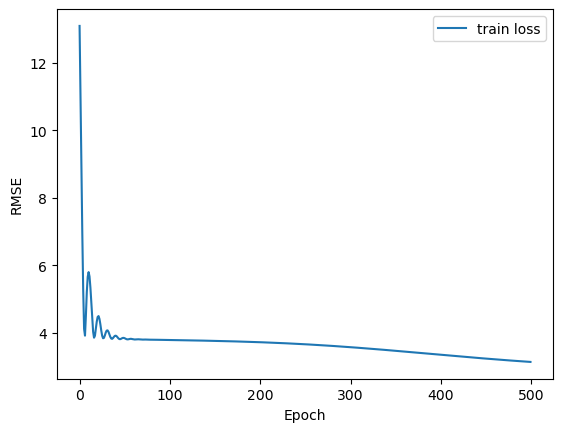

In [15]:
import matplotlib.pyplot as plt

# hist is the History object returned by .fit()
plt.plot(hist.history['loss'], label='train loss')

plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()


In [16]:
import copy
input_shapes = []
for i in range(len(X_test)):
    input_shapes.append(np.array(X_test[i]).shape[0])
m.set_input_shapes(input_shapes)

for i in range(len(X_test)):
    if X_test[i].shape[0] < 2000:
        new_list = np.zeros([2000 - X_test[i].shape[0], 41])
        X_test[i] = np.concatenate([X_test[i], new_list], 0)
X_test = np.array(X_test)
x_c = copy.deepcopy(X_test)
y_test = np.array(y_test)
y_pred_test = m.predict(X_test) 
y_pred_test = np.array(y_pred_test)
y_difference = np.mean(np.abs(np.abs(y_test) - np.abs(y_pred_test)))
eval = m.evaluate(X_test, y_test)
print("The mean absolute difference between y_tru & y_pred is : {}" .format(str(y_difference)))
print(y_pred_test)
print(y_test)




1/1 [==============================] - 7s 7s/step - loss: 2.4778
The mean absolute difference between y_tru & y_pred is : 1.3101387346899156
[[-0.0121755 ]
 [-2.4804068 ]
 [-1.7435293 ]
 [ 0.03807169]
 [ 0.8356028 ]
 [ 0.22166544]
 [-0.6844167 ]
 [ 2.5064402 ]
 [ 2.883607  ]
 [-0.4394216 ]
 [ 1.3659525 ]
 [-0.34461874]
 [ 1.8701029 ]
 [-0.5214986 ]
 [ 1.1382761 ]
 [ 1.4578104 ]
 [ 1.9614878 ]
 [-3.5596914 ]
 [ 1.5446177 ]
 [-2.9054098 ]
 [-2.9132223 ]]
[ 0.2    0.66   0.91  -0.87  -0.1   -0.8   -4.79   0.3   -1.2    0.68
 -0.3   -0.6    0.9   -3.59  -1.6    0.61   3.7    0.774 -2.049 -0.552
 -0.1  ]
